# Outlet Political Distribution

In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyreadr
import os
from tqdm import tqdm

os.chdir("GDELT_GKG/extras/Bias Ratings/")
from AllSides import allsides


In [2]:
# get data
robertson = pd.read_csv("robertson.csv",usecols=["domain","score"])
# shift score from -1 to 1 to 0 to 4
robertson["mod_score"] = (robertson["score"] + 1) * 2
robertson["mod_score"] = robertson["mod_score"].round(0)
# replace integers with class names
robertson["lean"] = robertson["mod_score"]#.replace({0:"left",1:"left lean",2:"least biased",3:"right lean",4:"right"})
# take subset and set index
robertson = robertson[["domain","lean"]]
robertson.set_index("domain", inplace=True)
robertson_leans = pd.Series(pd.Categorical(robertson.T.iloc[0,:]),index=robertson.index)

In [3]:
# get MBFC data
mbfc = pd.read_csv("MBFC_features.csv",usecols=["URL","Bias Rating"])
mbfc.set_index("URL",inplace=True)
#mbfc["Bias Rating"] = mbfc["Bias Rating"].replace({0:"left",1:"left lean",2:"least biased",3:"right lean",4:"right"})
# make it into series
mbfc_leans = pd.Series(pd.Categorical(mbfc.T.iloc[0,:]),index=mbfc.index)

In [4]:
# get AllSides Data
allsides = pd.Series(allsides)
allsides = allsides.replace({"left center":"left lean","right center":"right lean"})
allsides = allsides.replace({"left":0,"left lean":1,"least biased":2,"right lean":3,"right":4})

In [ ]:
allsides

### Get GDELT Predictions

In [ ]:
# go up one directory to "GDELT_GKG/extras"
os.chdir("..")
# get each batch that we made before, add it to list and then concat into final gdelt file
data_parts = []
for file in tqdm(os.listdir()):
    if file.startswith("robertson_outlets_part"):
        data_p = pd.read_csv("{}".format(file),usecols=["outlet"])
        data_parts.append(data_p)
        
gdelt_according_to_robertson = pd.concat(data_parts)


In [ ]:
gdelt_according_to_robertson.head()

In [ ]:
# for each dataset, change categorical leaning to lean score
# looking at the data, we forgot to add the score from Robertson, let's do that now
robertson_temp = pd.read_csv("Bias Ratings/robertson.csv",usecols=["domain","score"])
robertson_temp = robertson_temp.rename(columns={"domain":"outlet"})

# combine the score from robertson to our data
gdelt_according_to_robertson = gdelt_according_to_robertson.merge(robertson_temp, on="outlet", how='left')

In [ ]:
# shift score from -1 to 1 to 0 to 4
gdelt_according_to_robertson["mod_score"] = (gdelt_according_to_robertson["score"] + 1) * 2
gdelt_according_to_robertson["mod_score"] = gdelt_according_to_robertson["mod_score"].round(0)
# replace integers with class names
gdelt_according_to_robertson["lean"] = gdelt_according_to_robertson["mod_score"]

In [ ]:
gdelt_according_to_robertson.set_index("outlet", inplace=True)

In [ ]:
gdelt_according_to_robertson_s = pd.Series(pd.Categorical(
    gdelt_according_to_robertson.lean))

In [ ]:
#os.chdir("../..")
#gdelt_X = pd.read_csv("data/gdelt_exclude_MBFC_feature_elimination_remove_high_corr.csv")
#gdelt_X.set_index("outlet",inplace=True)

In [ ]:
# get a model
#model = joblib.load("results/best_SVC_model.sav")

In [ ]:
#gdelt_predicitions = pd.Series(model.predict(gdelt_X),index = gdelt_X.index)

## Make Histogram

In [5]:
# normalize all distributions
robertson_values = robertson_leans.value_counts()
robertson_values = robertson_values/robertson_values.sum()

mbfc_values = mbfc_leans.value_counts()
mbfc_values = mbfc_values/mbfc_values.sum()

allsides_values = allsides.value_counts()
allsides_values = allsides_values/allsides_values.sum()

#gdelt_values = gdelt_predicitions.value_counts()
#gdelt_values = gdelt_values/gdelt_values.sum()

#gdelt_robertson_values = gdelt_according_to_robertson_s.value_counts()
#gdelt_robertson_values = gdelt_robertson_values/gdelt_robertson_values.sum()

In [6]:
df = pd.DataFrame([robertson_values,mbfc_values,allsides_values]).T # gdelt_robertson_values
df.columns = ["Robertson Dataset","MBFC Dataset","AllSides Dataset"] # "GDELT_Robertson"
df.rename(index={0.0:'left',1.0:'left lean',2.0:'least biased', 3.0:'right lean', 4.0:'right'}, inplace=True)


In [7]:
df

,Robertson Dataset,MBFC Dataset,AllSides Dataset
least biased,0.464357,0.307592,0.427105
left lean,0.250920,0.238195,0.215606
right lean,0.187520,0.214714,0.106776
left,0.060561,0.085312,0.139630
right,0.036642,0.154187,0.110883


## Plot Proportions

In [8]:
df.drop("AllSides Dataset",axis=1,inplace=True)

Text(0.5, 0, 'Political Lean Label')

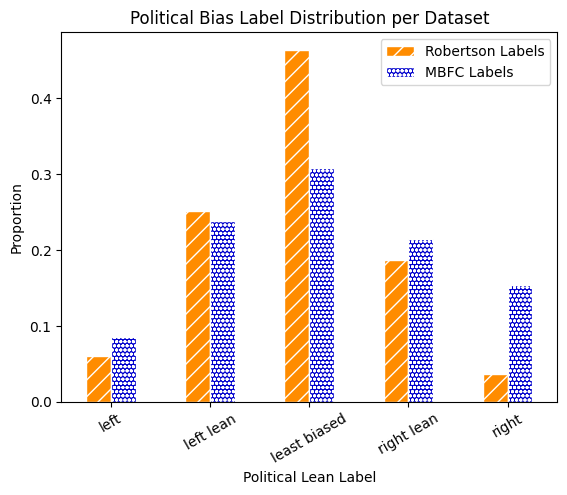

In [10]:
import matplotlib.patches as mpatches

categories = ["left","left lean","least biased","right lean","right"]
ax = df.loc[categories,:].plot(kind="bar",
                              color=["darkorange","mediumblue","gold","blue"],
                              title="Political Bias Label Distribution per Dataset",
                              rot=30,
                              )

legend_patches = []
# Assign hatch patterns to each column's bars
hatch_patterns = ['//']*5 + ['oooo']*5 #+ ['\\']*5 #+ ['-']*5 + ['+']*5 
colnames = ["Robertson Labels"]*5 + ["MBFC Labels"]*5 + ["Allsides Labels"]*5
last_colname = ""
for i, (colname,hatch) in enumerate(zip(colnames,hatch_patterns)):
    ax.patches[i].set_hatch(hatch)
    ax.patches[i].set_edgecolor('white')
    
    # Create a Patch object with the hatch pattern and add it to the legend
    patch = mpatches.Patch(facecolor=ax.patches[i].get_facecolor(),
                           edgecolor=ax.patches[i].get_edgecolor(),
                           hatch=hatch,
                           label=colname)
    if last_colname != colname:
        legend_patches.append(patch)
    last_colname = colname

# Create the legend using the custom patches
ax.legend(handles=legend_patches)

ax.set_ylabel("Proportion")
ax.set_xlabel("Political Lean Label")


In [ ]:
plt.savefig('BiasLabelDistrib.png', dpi=300)

### Plot Frequencies

In [11]:
label_freq = pd.DataFrame([pd.Series(robertson.value_counts()),mbfc.value_counts()])
#label_freq.loc["allsides"] = allsides.value_counts().values
label_freq.rename(index={0:"MBFC",1:"Robertson"},inplace=True)
label_freq = label_freq.T
label_freq.rename(index={0.0:'left',1.0:'left lean',2.0:'least biased', 3.0:'right lean', 4.0:'right'}, inplace=True)

label_freq

,MBFC,Robertson
least biased,8833,1179
left lean,4773,913
right lean,3567,823
left,1152,327
right,697,591


[Text(0, 0, 'left'),
 Text(1, 0, 'left lean'),
 Text(2, 0, 'least biased'),
 Text(3, 0, 'right lean'),
 Text(4, 0, 'right')]

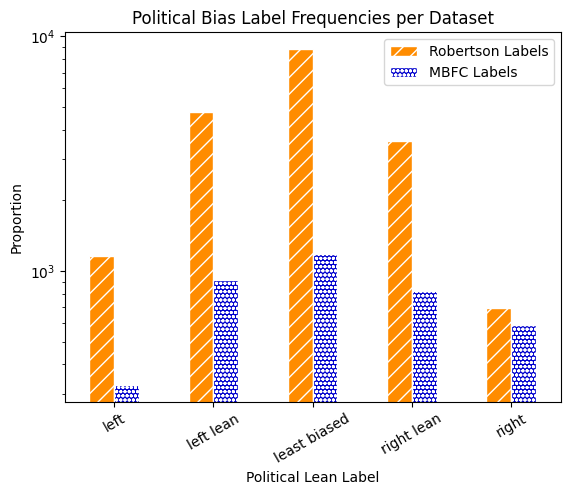

In [12]:
import matplotlib.patches as mpatches

categories = ["left","left lean","least biased","right lean","right"]
ax = label_freq.loc[categories,:].plot(kind="bar",
                              color=["darkorange","mediumblue","gold","blue"],
                              title="Political Bias Label Frequencies per Dataset",
                              rot=30,
                              )

legend_patches = []
# Assign hatch patterns to each column's bars
hatch_patterns = ['//']*5 + ['oooo']*5 #+ ['\\']*5 #+ ['-']*5 + ['+']*5 
colnames = ["Robertson Labels"]*5 + ["MBFC Labels"]*5 #+ ["Allsides Labels"]*5
last_colname = ""
for i, (colname,hatch) in enumerate(zip(colnames,hatch_patterns)):
    ax.patches[i].set_hatch(hatch)
    ax.patches[i].set_edgecolor('white')
    
    # Create a Patch object with the hatch pattern and add it to the legend
    patch = mpatches.Patch(facecolor=ax.patches[i].get_facecolor(),
                           edgecolor=ax.patches[i].get_edgecolor(),
                           hatch=hatch,
                           label=colname)
    if last_colname != colname:
        legend_patches.append(patch)
    last_colname = colname

# Create the legend using the custom patches
ax.legend(handles=legend_patches)

ax.set_ylabel("Proportion")
ax.set_xlabel("Political Lean Label")
ax.set_yscale('log')
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)

In [ ]:
os.listdir()

In [ ]:
plt.savefig('BiasLabelFreq.png', dpi=300)


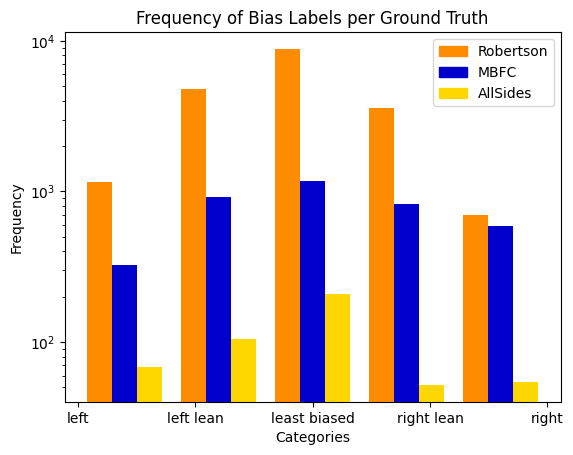

In [13]:
# Create a histogram for each series
plt.hist([robertson_leans,mbfc_leans,allsides],
         bins = 5,
         label = ["Robertson","MBFC","AllSides"],
         color = ["darkorange","mediumblue","gold"],
         hatch = ["/","o","+"],
         )

# Add a legend to the plot
handles, labels = plt.gca().get_legend_handles_labels()
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color, hatch=hatch)
                  for color, hatch in zip(["darkorange", "mediumblue", "gold"], ['/', '.', '\\'])]
plt.legend(handles=legend_handles, labels=labels, loc='upper right')

# Add axis labels and a title to the plot
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Frequency of Bias Labels per Ground Truth')
plt.yscale('log')
plt.xticks(np.arange(5),categories)

# Display the plot
plt.show()

# Compare Bias Ratings between Each Other

In [14]:
allsides_df = pd.DataFrame(allsides)
allsides_df.columns=["AllSides Lean"]

allsides_df

,AllSides Lean
abcnews.go.com,1
abovethelaw.com,1
medium.com,2
ajplus.net,0
aljazeera.com,1
...,...
wyomingpublicmedia.org,1
news.yahoo.com,1
vn.360plus.yahoo.com,2
yesmagazine.org,0


In [15]:
# GET OVERLAPS PER BIAS RATING DUO

# Robertson & MBFC
robertson.name = "robertson"
robertson.index.name = "outlet"
mbfc.name = "mbfc"
mbfc.index.name = "outlet"

rob_mbfc_overlap = pd.merge(robertson, mbfc, how='inner',on="outlet")

print("Number of Outlets in Robertson: ",robertson.shape[0])
print("Number of Outlets in MBFC: ", mbfc.shape[0])
print("Number of Outlets that overlap: ", rob_mbfc_overlap.shape[0])
print()

# Robertson & Allsides
allsides_df = pd.DataFrame(allsides)
allsides_df.columns = ["AllSides Lean"]
allsides_df.index.name = "outlet"

rob_allsides_overlap = pd.merge(robertson, allsides_df, how='inner',on="outlet")

print("Number of Outlets in Robertson: ",robertson.shape[0])
print("Number of Outlets in AllSides: ", allsides_df.shape[0])
print("Number of Outlets that overlap: ", rob_allsides_overlap.shape[0])
print()

# MBFC & Allsides

mbfc_allsides_overlap = pd.merge(mbfc, allsides_df, how='inner',on="outlet")

print("Number of Outlets in AllSides: ",allsides_df.shape[0])
print("Number of Outlets in MBFC: ", mbfc.shape[0])
print("Number of Outlets that overlap: ", mbfc_allsides_overlap.shape[0])



Number of Outlets in Robertson:  19022
Number of Outlets in MBFC:  3833
Number of Outlets that overlap:  1615

Number of Outlets in Robertson:  19022
Number of Outlets in AllSides:  487
Number of Outlets that overlap:  354

Number of Outlets in AllSides:  487
Number of Outlets in MBFC:  3833
Number of Outlets that overlap:  293


In [ ]:
print("Between Robertson and MBFC, of the outlets that are common to the two...")
rob_mbfc_match = rob_mbfc_overlap[rob_mbfc_overlap["lean"] == rob_mbfc_overlap["Bias Rating"]]
print("{}/{} outlet leans match".format(rob_mbfc_match.shape[0], rob_mbfc_overlap.shape[0]))
print("This is {}%".format(round(rob_mbfc_match.shape[0]/rob_mbfc_overlap.shape[0],3)))

In [ ]:
print("Between Robertson and Allsides, of the outlets that are common to the two...")
rob_alls_match = rob_allsides_overlap[rob_allsides_overlap["lean"] == rob_allsides_overlap["AllSides Lean"]]
print("{}/{} outlet leans match".format(rob_alls_match.shape[0], rob_allsides_overlap.shape[0]))
print("This is {}%".format(round(rob_alls_match.shape[0]/rob_allsides_overlap.shape[0],3)))

In [ ]:
print("Between MBFC and Allsides, of the outlets that are common to the two...")
mbfc_alls_match = mbfc_allsides_overlap[mbfc_allsides_overlap["Bias Rating"] == mbfc_allsides_overlap["AllSides Lean"]]
print("{}/{} outlet leans match".format(mbfc_alls_match.shape[0], mbfc_allsides_overlap.shape[0]))
print("This is {}%".format(round(mbfc_alls_match.shape[0]/mbfc_allsides_overlap.shape[0],3)))

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


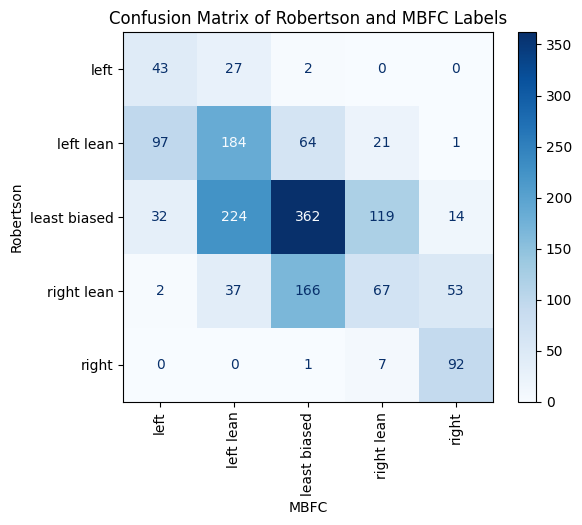

In [17]:
cm = confusion_matrix(rob_mbfc_overlap["lean"], rob_mbfc_overlap["Bias Rating"])
disp = ConfusionMatrixDisplay(cm,
                              display_labels = categories,
                              #cmap=plt.cm.Blues,
                             )

disp.plot(cmap=plt.cm.Blues,xticks_rotation="vertical",)
disp.ax_.set_title("Confusion Matrix of Robertson and MBFC Labels")
plt.xlabel('MBFC')
plt.ylabel('Robertson')
plt.legend().remove()

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score


def get_AUC_scores(y_test,y_pred):
    """
    Since we need to use OneHotEncoded values for AUC, we'll do that here separately.
    We also calculate the AUC per class, and also its average. Then put this in
    array and pad it so it fits into the report DataFrame.
    """
    ohe = OneHotEncoder()
    out = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()
    y_test_ohe = pd.DataFrame(out, index=y_test.index)
    # get same shape for predictions
    out = ohe.transform(y_pred.reshape(-1, 1)).toarray()
    y_pred_ohe = pd.DataFrame(out, index=y_test.index)
    
    # compute actual scores
    AUC_avg = roc_auc_score(y_test_ohe,y_pred_ohe, multi_class='ovr')
    AUC_per_class = roc_auc_score(y_test_ohe,y_pred_ohe, average=None,multi_class='ovr')
    # add AUC to report DF
    AUC_list = np.append(AUC_per_class,AUC_avg)
    AUC_list = np.append(AUC_list, [0,0]) # add padding so it fits into DF
    
    return AUC_list

In [28]:
get_AUC_scores(rob_mbfc_overlap["lean"], rob_mbfc_overlap["Bias Rating"].values)

array([0.75616134, 0.63529658, 0.60617402, 0.54610018, 0.93755776,
       0.69625798, 0.        , 0.        ])

In [29]:
get_AUC_scores(mbfc_allsides_overlap["Bias Rating"], mbfc_allsides_overlap["AllSides Lean"].values)

array([0.78739264, 0.67166582, 0.76509434, 0.6650666 , 0.82545932,
       0.74293574, 0.        , 0.        ])